In [1]:
import os, sys, glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import yaml



from py2d.initialize import initialize_wavenumbers_rfft2, gridgen, initialize_wavenumbers_fft2

# import the modules
from analysis.metrics import corr_truth_train_model, rmse_truth_train_model
from analysis.return_period import return_period_bins, ensemble_return_period_amplitude, return_period_empirical
from analysis.io_utils import data2density
from analysis.plot_config import params, contourLevels, colormap
os.environ["PATH"] = f"/home/exouser/karan2/texlive/2025/bin/x86_64-linux:" + os.environ["PATH"] # use path of installed texlive

plt.rcParams.update(params)


# ===== EMULATOR CONFIGURATION =====
EMULATORS_B2500 = [
    {
        'name': r'Static',
        'root_dir': '/home/exouser/karan2/2DTurbDiffusion/results/UDM_s3_Oaw_lrC3e4/',
        'run_name': 'all',
        'color': 'b',
        'style': '-.'
    },
    {
        'name': r'Dynamic', 
        'root_dir': '/home/exouser/karan2/2DTurbDiffusion/results/CDM_s3_Oaw_lrC3e4/',
        'run_name': 'all',
        'color': 'g',
        'style': '-.'
    }
]
EMULATORS_A2500 = [
    {
        'name': r'Static',
        'root_dir': '/home/exouser/karan2/2DTurbDiffusion/results/UDM_s2_Oaw_lrC3e4_e800_2500/',
        'run_name': 'all',
        'color': 'b',
        'style': '-.'
    },
    {
        'name': r'Dynamic',
        'root_dir': '/home/exouser/karan2/2DTurbDiffusion/results/CDM_s3_Oaw_lrC3e4_e800_2500/',
        'run_name': 'all',
        'color': 'g',
        'style': '-.'
    }
]
EMULATORS_A25000 = [
    {
        'name': r'Static',
        'root_dir': '/home/exouser/karan2/2DTurbDiffusion/results/UDM_s1_Oaw_lrC3e4_e800_25000/',
        'run_name': 'all',
        'color': 'b',
        'style': '-.'
    },
    {
        'name': r'Dynamic',
        'root_dir': '/home/exouser/karan2/2DTurbDiffusion/results/CDM_s3_Oaw_lrC3e4_e800_25000/',
        'run_name': 'all',
        'color': 'g',
        'style': '-.'
    }
]
EMULATOR_ALL_GEN_B2500 = [
    {
        'name': r'gen 1',
        'root_dir': '/home/exouser/karan2/2DTurbDiffusion/results/UDM_s3_Oaw_lrC3e4/',
        'run_name': 'all',
        'color': 'b',
        'style': '-.'
    },
    {
        'name': r'gen 5',
        'root_dir': '/home/exouser/karan2/2DTurbDiffusion/results/UDM_s3_Oaw_lrC3e4_all_gen_4/',
        'run_name': 'all',
        'color': 'g',
        'style': '-.'
    },
    {
        'name': r'gen 10',
        'root_dir': '/home/exouser/karan2/2DTurbDiffusion/results/UDM_s3_Oaw_lrC3e4_all_gen_9/',
        'run_name': 'all',
        'color': 'c',
        'style': '-.'
    }
]

# ===== TRUTH AND TRAINING PATHS =====

# analysis_dir_train = '/home/exouser/karan2/2DTurbDiffusion/eval/results/train_step1_5000_7500/analysis/train/'
analysis_dir_train_B2500 = '/home/exouser/karan2/2DTurbDiffusion/eval/results/train_step3_10000_17500/analysis/train/'
analysis_dir_train_A2500 = '/home/exouser/karan2/2DTurbDiffusion/eval/results/train_step3_400000_407500/analysis/train/'
analysis_dir_train_A25000 = '/home/exouser/karan2/2DTurbDiffusion/eval/results/train_step3_400000_475000/analysis/train/'


# analysis_dir_truth = '/home/exouser/karan2/2DTurbDiffusion/eval/results/truth_Re500_fkx4fky4_r0.1_b20_dt0.02_25000000/A/'
analysis_dir_truth = '/home/exouser/karan2/2DTurbDiffusion/eval/results/truth/A/'

# ===== FUNCTION TO SETUP EMULATOR ANALYSIS DIRECTORY =====
def setup_emulator_analysis(root_dir, run_name):
    """Setup analysis directory and config for an emulator"""
    yaml_files = glob.glob(os.path.join(root_dir, "*.yaml"))
    if len(yaml_files) == 0:
        raise FileNotFoundError(f"No .yaml files found in {root_dir}")
    
    with open(yaml_files[0], 'r') as f:
        config = yaml.safe_load(f)
    
    diffusion_config = config['diffusion_params']
    model_config = config['model_params']

    if diffusion_config['conditional'] and run_name != 'all':
        analysis_dir = os.path.join(root_dir, "analysis", "emulator", run_name)
        plt_save_dir = os.path.join(root_dir, "figures", run_name)

    else:
        analysis_dir = os.path.join(root_dir, "analysis", "emulator")
        plt_save_dir = os.path.join(root_dir, "figures")
    
    return analysis_dir, _, config

Nx, Ny = 64, 64  # Assuming Nx and Ny are defined here, adjust as needed

analysis_dir_arr = [analysis_dir_truth, analysis_dir_train_A2500]
label = [r'Truth', r'Train']
colors_markers = ['-k', '--r']
color=['k', 'r']

for emulator in EMULATOR_ALL_GEN_B2500:
    analysis_dir_emulator, _, config = setup_emulator_analysis(emulator['root_dir'], emulator['run_name'])
    analysis_dir_arr.append(analysis_dir_emulator)
    label.append(emulator['name'])
    colors_markers.append(emulator['style'] + emulator['color'])
    color.append(emulator['color'])
    Nx, Ny = config['model_params']['im_size'], config['model_params']['im_size']

plt_save_dir = 'paper_figures/'

Lx, Ly = 2*np.pi, 2*np.pi
dt_DNS = 0.0005
dt_emulator = 0.02


Lx, Ly, X, Y, dx, dy = gridgen(Lx, Ly, Nx, Ny, INDEXING='ij')
TRAIN_label_arr = ['A', 'B', 'A10x', 'all_gen']
TRAIN_ARR = [analysis_dir_train_A2500, analysis_dir_train_B2500 , analysis_dir_train_A25000, analysis_dir_train_B2500]

EMULATOR_ARR = [EMULATORS_A2500, EMULATORS_B2500, EMULATORS_A25000, EMULATOR_ALL_GEN_B2500]

<>:97: SyntaxWarning: invalid escape sequence '\h'
<>:97: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipykernel_3168264/3815377298.py:97: SyntaxWarning: invalid escape sequence '\h'
  axes[count+1,3].set_title('$|\hat{u}|$', rotation=0)


Loading spectra from /home/exouser/karan2/2DTurbDiffusion/eval/results/truth/A//spectra.npz
Loading spectra from /home/exouser/karan2/2DTurbDiffusion/eval/results/train_step3_400000_407500/analysis/train//spectra.npz
Loading spectra from /home/exouser/karan2/2DTurbDiffusion/results/UDM_s2_Oaw_lrC3e4_e800_2500/analysis/emulator/spectra.npz
Loading spectra from /home/exouser/karan2/2DTurbDiffusion/results/CDM_s3_Oaw_lrC3e4_e800_2500/analysis/emulator/spectra.npz
Loading spectra from /home/exouser/karan2/2DTurbDiffusion/eval/results/truth/A//spectra.npz
Loading spectra from /home/exouser/karan2/2DTurbDiffusion/eval/results/train_step3_10000_17500/analysis/train//spectra.npz
Loading spectra from /home/exouser/karan2/2DTurbDiffusion/results/UDM_s3_Oaw_lrC3e4/analysis/emulator/spectra.npz
Loading spectra from /home/exouser/karan2/2DTurbDiffusion/results/CDM_s3_Oaw_lrC3e4/analysis/emulator/spectra.npz
Loading spectra from /home/exouser/karan2/2DTurbDiffusion/eval/results/truth/A//spectra.npz


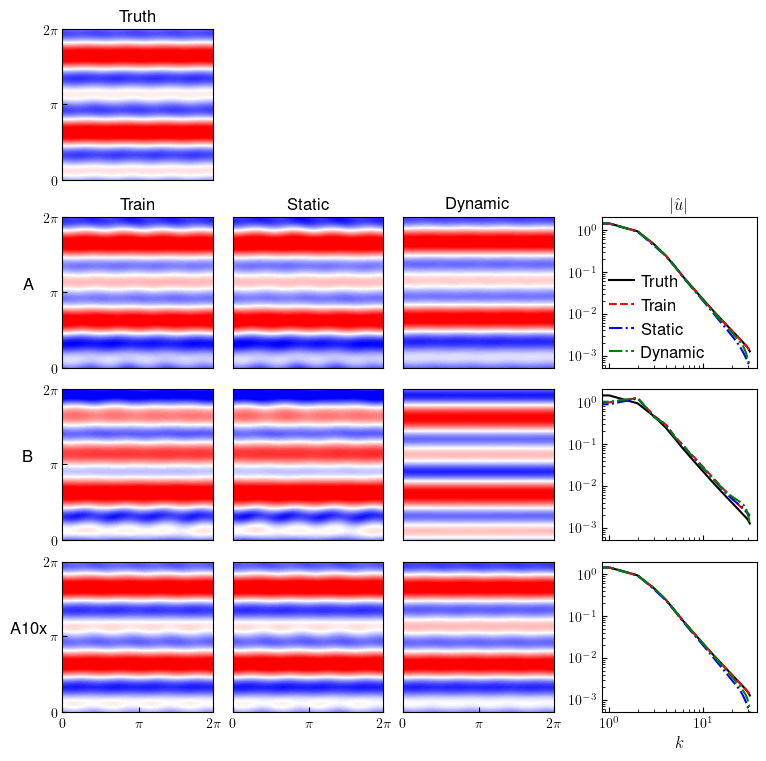

In [2]:
fig, axes = plt.subplots(4,4,figsize=(8, 7.5), layout="compressed")  # Adjust figure size as needed

contourLevels = 100
# ===== PLOTTING SETUP =====


for count in range(4):

    if count == 0:
        analysis_dir_arr = [analysis_dir_truth]
        
    else:
        analysis_dir_arr = [TRAIN_ARR[count-1]]
        for emulator in EMULATOR_ARR[count-1]:
            analysis_dir_emulator, _, config = setup_emulator_analysis(emulator['root_dir'], emulator['run_name'])
            analysis_dir_arr.append(analysis_dir_emulator)

    for i, analysis_dir in enumerate(analysis_dir_arr):

        data = np.load(analysis_dir + "/temporal_mean.npz")
        # data = np.load(analysis_dir_truth + "/temporal_mean.npz")

        U_mean_sample = data['U_sample_mean']
        V_mean_sample = data['V_sample_mean']
        Omega_mean_sample = data['Omega_sample_mean']

        if i == 0:
            vmax_U = 0.8*np.max(U_mean_sample)
            vmax_V = 0.8*np.max(V_mean_sample)
            vmax_Omega = 0.8*np.max(Omega_mean_sample)

        axes[count,i].contourf(X,Y,U_mean_sample.T, levels=contourLevels, cmap=colormap, vmax=vmax_U, vmin=-vmax_U)
        # axes[count,i].contourf(X,Y,V_mean_sample.T, levels=contourLevels, cmap=colormap, vmax=vmax_V, vmin=-vmax_V)
        # axes[count,i].contourf(X,Y,Omega_mean_sample.T, levels=contourLevels, cmap=colormap, vmax=vmax_Omega, vmin=-vmax_Omega)

        # axes[0,i].set_title(rf"$u$ {label[i]}")
        # axes[1,i].set_title(rf"$v$ {label[i]}")
        axes[count,i].set_aspect('equal')
        axes[count,i].set_xticks([])
        axes[count,i].set_yticks([])

        if i == 0:
            axes[count,i].set_yticks([0, np.pi, 2*np.pi-dx])
            axes[count,i].set_yticklabels([r"$0$", r"$\pi$", r"$2\pi$"])
            if count > 0:
                axes[count,i].set_ylabel(f"{TRAIN_label_arr[count-1]}", rotation=0, labelpad=10)

        if count == 0:
            axes[count,i].set_title(rf"{label[i]}")

            for i in range(1,4):
                axes[count,i].set_visible(False)

        elif count == 1:
            axes[count,i].set_title(rf"{label[i+1]}")



        if count == 3:
            axes[count,i].set_xticks([0, np.pi, 2*np.pi-dx])
            axes[count,i].set_xticklabels([r"$0$", r"$\pi$", r"$2\pi$"])



for count in range(3):
    analysis_dir_arr = [analysis_dir_truth, TRAIN_ARR[count]]
    
    for emulator in EMULATOR_ARR[count]:
        analysis_dir_emulator, _, config = setup_emulator_analysis(emulator['root_dir'], emulator['run_name'])
        analysis_dir_arr.append(analysis_dir_emulator)


    for i, analysis_dir in enumerate(analysis_dir_arr):

        data = np.load(analysis_dir + "/spectra.npz")
        print(f"Loading spectra from {analysis_dir}/spectra.npz")

        U_spectra = data['spectra_U_zonal_avg']
        V_spectra = data['spectra_V_zonal_avg']
        Omega_spectra = data['spectra_Omega_zonal_avg']
        wavenumbers = data['wavenumber_zonal_avg']

        # U_spectra = data['spectra_U_angular_avg']
        # V_spectra = data['spectra_V_angular_avg']
        # Omega_spectra = data['spectra_Omega_angular_avg']
        # wavenumbers = data['wavenumber_angular_avg']

        axes[count+1,3].loglog(wavenumbers[:-1], U_spectra[:-1], colors_markers[i], label=label[i])
        # axes[count+1,3].loglog(wavenumbers[:-1], V_spectra[:-1], colors_markers[i], label=label[i])
        # axes[count+1,3].loglog(wavenumbers[:-1], Omega_spectra[:-1], colors_markers[i], label=label[i])

        axes[count+1,3].set_ylim([5e-4, 2e0])

        # axes[0].set_title('$\hat{u}$', rotation=0)
        # axes[1].set_title('$\hat{v}$', rotation=0)
        if count == 0:
            axes[count+1,3].set_title('$|\hat{u}|$', rotation=0)
            axes[count+1,3].legend(frameon=False, loc='lower left', bbox_to_anchor=(-0.05, -0.05), handlelength=1.5, handletextpad=0.4)

        if count == 2:
            axes[count+1,3].set_xlabel('$k$')
        else:
            axes[count+1,3].set_xticklabels([])

plt.savefig(os.path.join(plt_save_dir, 'u_sample_mean_spectra.jpg'), dpi=600, bbox_inches='tight')

Return Period for Training Data A
Shapes U_max:(9510016,), (38, 250000), U_min: (9510016,) (38, 250000)
Shapes U_max:(2501,), (1, 2501), U_min: (2501,) (1, 2501)
Shapes U_max:(556320,), (2, 250000), U_min: (556320,) (2, 250000)
Shapes U_max:(739424,), (2, 250000), U_min: (739424,) (2, 250000)
Shapes U_max:(4755008,), (19, 250000), U_min: (4755008,) (19, 250000)
Shapes U_max:(2501,), (1, 2501), U_min: (2501,) (1, 2501)
Shapes U_max:(556320,), (2, 250000), U_min: (556320,) (2, 250000)
Shapes U_max:(739424,), (2, 250000), U_min: (739424,) (2, 250000)
Return Period for Training Data B
Shapes U_max:(9510016,), (38, 250000), U_min: (9510016,) (38, 250000)
Shapes U_max:(2501,), (1, 2501), U_min: (2501,) (1, 2501)
Shapes U_max:(784000,), (3, 250000), U_min: (784000,) (3, 250000)
Shapes U_max:(1250002,), (5, 250000), U_min: (1250002,) (5, 250000)
Shapes U_max:(4755008,), (19, 250000), U_min: (4755008,) (19, 250000)
Shapes U_max:(2501,), (1, 2501), U_min: (2501,) (1, 2501)
Shapes U_max:(784000,)

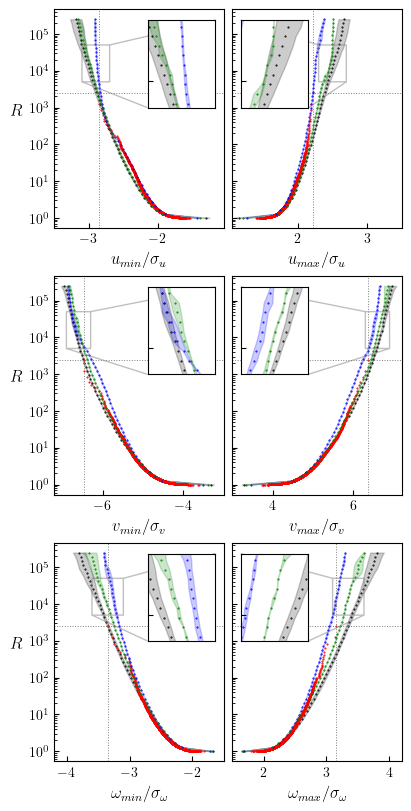

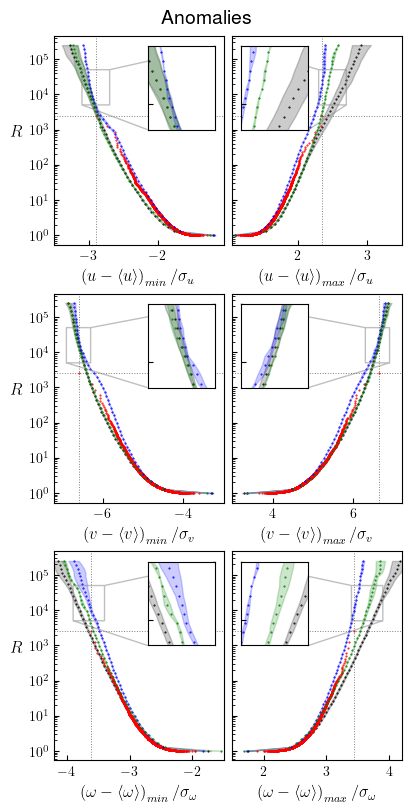

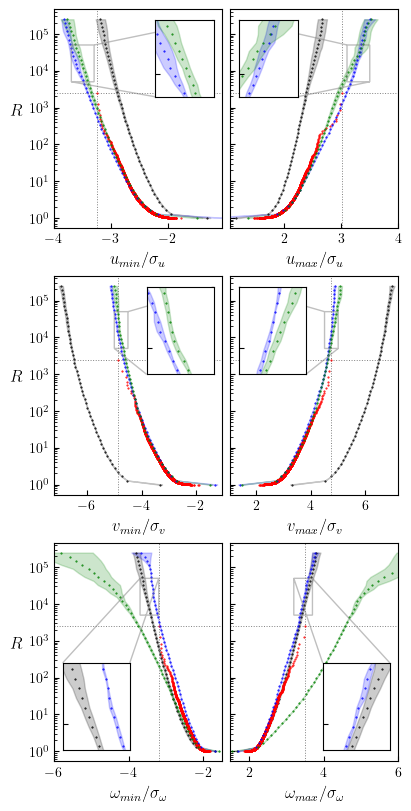

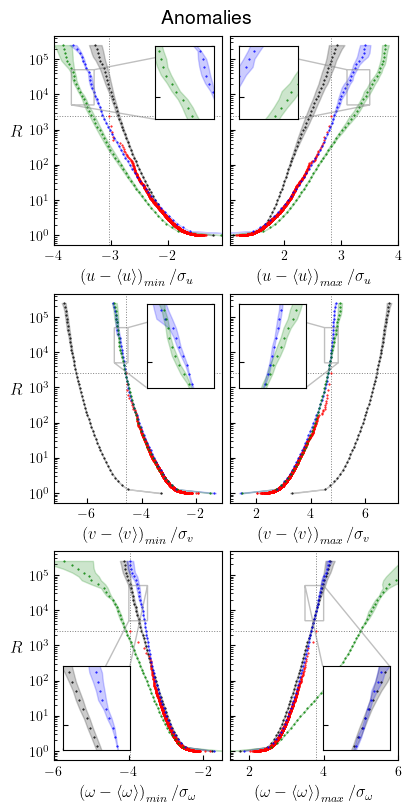

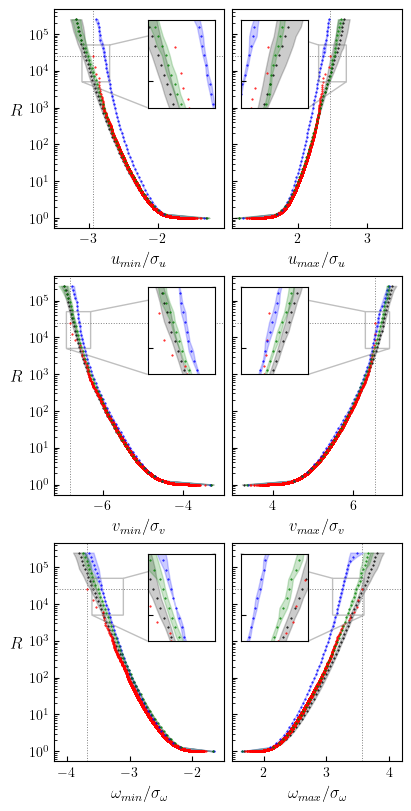

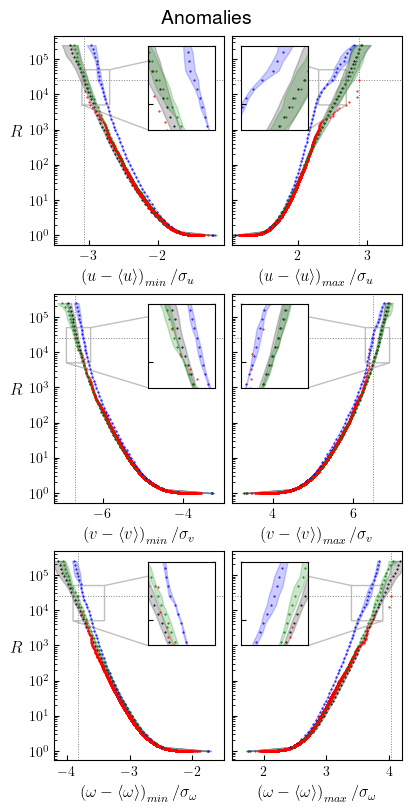

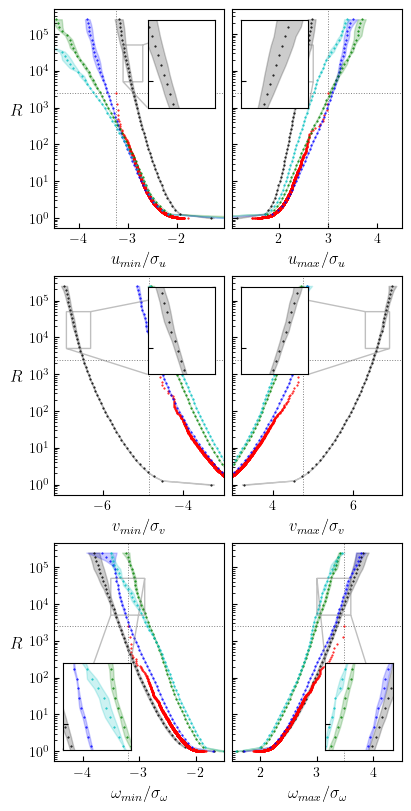

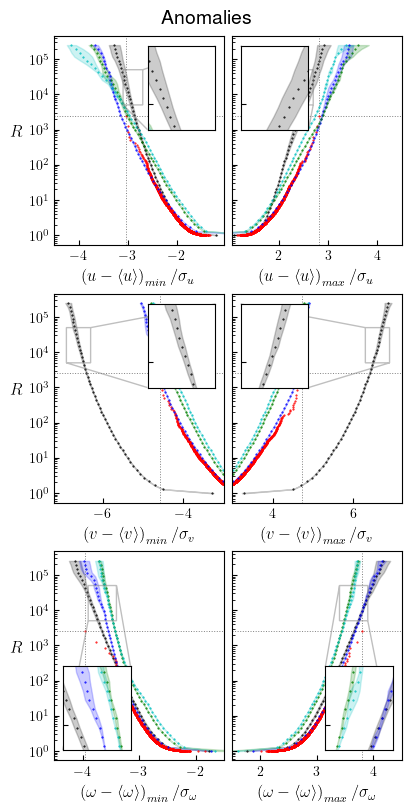

In [7]:

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

dt_data = 1
markersize = 0.5
U_std = 2.34
V_std = 1.88
Omega_std = 10.41
bins_num = 50

length_data = 250000  # Length of data for return period calculation

central_tendency = 'mean'  # mean median
error_bands = 'std'  # std 95ci 50ci

split = True
split_size = 2 # number of splits

def reshape_data_chunks(arr, target_length):
    """
    Reshape array into chunks of target_length, discarding extra data.
    
    Parameters:
    arr : array-like
        Input array to reshape
    target_length : int
        Target length for each chunk
        
    Returns:
    numpy.ndarray
        Reshaped array with shape [n_chunks, target_length] or [1, arr_length] if insufficient data
    """
    arr = np.asarray(arr)
    n_chunks = len(arr) // target_length
    if n_chunks > 0:
        return arr[:n_chunks * target_length].reshape(n_chunks, target_length)
    else:
        return arr.reshape(1, -1)  # If less than target_length elements, keep as single row


for count in range(4):
    analysis_dir_arr = [analysis_dir_truth, TRAIN_ARR[count]]
    
    for emulator in EMULATOR_ARR[count]:
        analysis_dir_emulator, _, config = setup_emulator_analysis(emulator['root_dir'], emulator['run_name'])
        analysis_dir_arr.append(analysis_dir_emulator)

    print(f"Return Period for Training Data {TRAIN_label_arr[count]}")


    for anom in [False, True]:
    # for anom in [False]:

        fig, axes = plt.subplots(3, 2, figsize=(4, 8), layout='constrained')
        plt.rcParams.update(params)


        if TRAIN_label_arr[count] == 'A' or TRAIN_label_arr[count] == 'A10x':
            axins00 = axes[0,0].inset_axes([0.55, 0.55, 0.4, 0.4])
            axins01 = axes[0,1].inset_axes([0.05, 0.55, 0.4, 0.4])
            axins10 = axes[1,0].inset_axes([0.55, 0.55, 0.4, 0.4])
            axins11 = axes[1,1].inset_axes([0.05, 0.55, 0.4, 0.4])
            axins20 = axes[2,0].inset_axes([0.55, 0.55, 0.4, 0.4])
            axins21 = axes[2,1].inset_axes([0.05, 0.55, 0.4, 0.4])

        elif TRAIN_label_arr[count] == 'B':
            axins00 = axes[0,0].inset_axes([0.6, 0.6, 0.35, 0.35])
            axins01 = axes[0,1].inset_axes([0.05, 0.6, 0.35, 0.35])
            axins10 = axes[1,0].inset_axes([0.55, 0.55, 0.4, 0.4])
            axins11 = axes[1,1].inset_axes([0.05, 0.55, 0.4, 0.4])
            axins20 = axes[2,0].inset_axes([0.05, 0.05, 0.4, 0.4])
            axins21 = axes[2,1].inset_axes([0.55, 0.05, 0.4, 0.4])

        elif TRAIN_label_arr[count] == 'all_gen':
            axins00 = axes[0,0].inset_axes([0.55, 0.55, 0.4, 0.4])
            axins01 = axes[0,1].inset_axes([0.05, 0.55, 0.4, 0.4])
            axins10 = axes[1,0].inset_axes([0.55, 0.55, 0.4, 0.4])
            axins11 = axes[1,1].inset_axes([0.05, 0.55, 0.4, 0.4])
            axins20 = axes[2,0].inset_axes([0.05, 0.05, 0.4, 0.4])
            axins21 = axes[2,1].inset_axes([0.55, 0.05, 0.4, 0.4])

        for i, analysis_dir in enumerate(analysis_dir_arr):

            if anom:
                data = np.load(os.path.join(analysis_dir, 'extremes_anom.npz'))
            else:
                data = np.load(os.path.join(analysis_dir, 'extremes.npz'))

            U_max_arr = data['U_max_arr']/U_std
            U_min_arr = data['U_min_arr']/U_std
            V_max_arr = data['V_max_arr']/V_std
            V_min_arr = data['V_min_arr']/V_std
            Omega_max_arr = data['Omega_max_arr']/Omega_std
            Omega_min_arr = data['Omega_min_arr']/Omega_std
            arr = np.asarray(U_max_arr)

            # Apply the function
            U_max_arr_split = reshape_data_chunks(U_max_arr, length_data)
            U_min_arr_split = reshape_data_chunks(U_min_arr, length_data)
            V_max_arr_split = reshape_data_chunks(V_max_arr, length_data)
            V_min_arr_split = reshape_data_chunks(V_min_arr, length_data)
            Omega_max_arr_split = reshape_data_chunks(Omega_max_arr, length_data)
            Omega_min_arr_split = reshape_data_chunks(Omega_min_arr, length_data)


            print(f"Shapes U_max:{np.asarray(U_max_arr).shape}, {U_max_arr_split.shape}, U_min: {np.asarray(U_min_arr).shape} {U_min_arr_split.shape}")
            # print(f"Shapes V_max:{np.asarray(V_max_arr).shape}, {V_max_arr_split.shape}, V_min: {np.asarray(V_min_arr).shape} {V_min_arr_split.shape}")
            # print(f"Shapes Omega_max: {np.asarray(Omega_max_arr).shape} {Omega_max_arr_split.shape}, Omega_min: {np.asarray(Omega_min_arr).shape} {Omega_min_arr_split.shape}")

            if analysis_dir in TRAIN_ARR:

                U_max_return_period, U_max_data_amplitude = return_period_empirical(U_max_arr, dt=dt_data)
                U_min_return_period, U_min_data_amplitude = return_period_empirical(np.abs(U_min_arr), dt=dt_data)
                V_max_return_period, V_max_data_amplitude = return_period_empirical(V_max_arr, dt=dt_data)
                V_min_return_period, V_min_data_amplitude = return_period_empirical(np.abs(V_min_arr), dt=dt_data)
                Omega_max_return_period, Omega_max_data_amplitude = return_period_empirical(Omega_max_arr, dt=dt_data)
                Omega_min_return_period, Omega_min_data_amplitude = return_period_empirical(np.abs(Omega_min_arr), dt=dt_data)

                axes[0,0].axvline(-np.max(U_min_data_amplitude), color='grey', linestyle=':', linewidth=0.7)
                axes[0,0].axhline(np.max(U_min_return_period), color='grey', linestyle=':', linewidth=0.7)

                axes[0,1].axvline(np.max(U_max_data_amplitude), color='grey', linestyle=':', linewidth=0.7)
                axes[0,1].axhline(np.max(U_max_return_period), color='grey', linestyle=':', linewidth=0.7)

                axes[1,0].axvline(-np.max(V_min_data_amplitude), color='grey', linestyle=':', linewidth=0.7)
                axes[1,0].axhline(np.max(V_min_return_period), color='grey', linestyle=':', linewidth=0.7)

                axes[1,1].axvline(np.max(V_max_data_amplitude), color='grey', linestyle=':', linewidth=0.7)
                axes[1,1].axhline(np.max(V_max_return_period), color='grey', linestyle=':', linewidth=0.7)

                axes[2,0].axvline(-np.max(Omega_min_data_amplitude), color='grey', linestyle=':', linewidth=0.7)
                axes[2,0].axhline(np.max(Omega_min_return_period), color='grey', linestyle=':', linewidth=0.7)

                axes[2,1].axvline(np.max(Omega_max_data_amplitude), color='grey', linestyle=':', linewidth=0.7)
                axes[2,1].axhline(np.max(Omega_max_return_period), color='grey', linestyle=':', linewidth=0.7)


            else:
                U_max_return_period, U_max_data_amplitude, U_max_data_amplitude_lb, U_max_data_amplitude_ub = ensemble_return_period_amplitude(
                    np.asarray(np.abs(U_max_arr_split)), dt=dt_data, bins_num=bins_num, central_tendency=central_tendency, error_bands=error_bands)
                U_min_return_period, U_min_data_amplitude, U_min_data_amplitude_lb, U_min_data_amplitude_ub = ensemble_return_period_amplitude(
                    np.asarray(np.abs(U_min_arr_split)), dt=dt_data, bins_num=bins_num, central_tendency=central_tendency, error_bands=error_bands)
                V_max_return_period, V_max_data_amplitude, V_max_data_amplitude_lb, V_max_data_amplitude_ub = ensemble_return_period_amplitude(
                    np.asarray(np.abs(V_max_arr_split)), dt=dt_data, bins_num=bins_num, central_tendency=central_tendency, error_bands=error_bands)
                V_min_return_period, V_min_data_amplitude, V_min_data_amplitude_lb, V_min_data_amplitude_ub = ensemble_return_period_amplitude(
                    np.asarray(np.abs(V_min_arr_split)), dt=dt_data, bins_num=bins_num, central_tendency=central_tendency, error_bands=error_bands)
                Omega_max_return_period, Omega_max_data_amplitude, Omega_max_data_amplitude_lb, Omega_max_data_amplitude_ub = ensemble_return_period_amplitude(
                    np.asarray(np.abs(Omega_max_arr_split)), dt=dt_data, bins_num=bins_num, central_tendency=central_tendency, error_bands=error_bands)
                Omega_min_return_period, Omega_min_data_amplitude, Omega_min_data_amplitude_lb, Omega_min_data_amplitude_ub = ensemble_return_period_amplitude(
                    np.asarray(np.abs(Omega_min_arr_split)), dt=dt_data, bins_num=bins_num, central_tendency=central_tendency, error_bands=error_bands)


            axes[0,0].semilogy(-U_min_data_amplitude, U_min_return_period, 'o' + color[i],  markersize=markersize, label=label[i])
            axes[0,1].semilogy(U_max_data_amplitude, U_max_return_period, 'o' + color[i],  markersize=markersize, label=label[i])
            axes[1,0].semilogy(-V_min_data_amplitude, V_min_return_period, 'o' + color[i],  markersize=markersize, label=label[i])
            axes[1,1].semilogy(V_max_data_amplitude, V_max_return_period, 'o' + color[i],  markersize=markersize, label=label[i])
            axes[2,0].semilogy(-Omega_min_data_amplitude, Omega_min_return_period, 'o' + color[i],  markersize=markersize, label=label[i])
            axes[2,1].semilogy(Omega_max_data_amplitude, Omega_max_return_period, 'o' + color[i],  markersize=markersize, label=label[i])
            

            if analysis_dir not in TRAIN_ARR:
                axes[0,0].fill_betweenx(U_min_return_period, -U_min_data_amplitude_ub, -U_min_data_amplitude_lb, color=color[i], alpha=0.2)
                axes[0,1].fill_betweenx(U_max_return_period, U_max_data_amplitude_lb, U_max_data_amplitude_ub, color=color[i], alpha=0.2)
                axes[1,0].fill_betweenx(V_min_return_period, -V_min_data_amplitude_ub, -V_min_data_amplitude_lb, color=color[i], alpha=0.2)
                axes[1,1].fill_betweenx(V_max_return_period, V_max_data_amplitude_lb, V_max_data_amplitude_ub, color=color[i], alpha=0.2)
                axes[2,0].fill_betweenx(Omega_min_return_period, -Omega_min_data_amplitude_ub, -Omega_min_data_amplitude_lb, color=color[i], alpha=0.2)
                axes[2,1].fill_betweenx(Omega_max_return_period, Omega_max_data_amplitude_lb, Omega_max_data_amplitude_ub, color=color[i], alpha=0.2)

########### Inset Axes for Zooming ###########
            # Create inset axes for zooming into axes[0,0]

            axins00.semilogy(-U_min_data_amplitude, U_min_return_period, 'o' + color[i], markersize=markersize)
            axins01.semilogy(U_max_data_amplitude, U_max_return_period, 'o' + color[i], markersize=markersize)
            axins10.semilogy(-V_min_data_amplitude, V_min_return_period, 'o' + color[i], markersize=markersize)
            axins11.semilogy(V_max_data_amplitude, V_max_return_period, 'o' + color[i], markersize=markersize)
            axins20.semilogy(-Omega_min_data_amplitude, Omega_min_return_period, 'o' + color[i], markersize=markersize)
            axins21.semilogy(Omega_max_data_amplitude, Omega_max_return_period, 'o' + color[i], markersize=markersize)

            if analysis_dir not in TRAIN_ARR:
                axins00.fill_betweenx(U_min_return_period, -U_min_data_amplitude_ub, -U_min_data_amplitude_lb, color=color[i], alpha=0.2)
                axins01.fill_betweenx(U_max_return_period, U_max_data_amplitude_lb, U_max_data_amplitude_ub, color=color[i], alpha=0.2)
                axins10.fill_betweenx(V_min_return_period, -V_min_data_amplitude_ub, -V_min_data_amplitude_lb, color=color[i], alpha=0.2)
                axins11.fill_betweenx(V_max_return_period, V_max_data_amplitude_lb, V_max_data_amplitude_ub, color=color[i], alpha=0.2)
                axins20.fill_betweenx(Omega_min_return_period, -Omega_min_data_amplitude_ub, -Omega_min_data_amplitude_lb, color=color[i], alpha=0.2)
                axins21.fill_betweenx(Omega_max_return_period, Omega_max_data_amplitude_lb, Omega_max_data_amplitude_ub, color=color[i], alpha=0.2)

        if anom:
            axes[0,0].set_xlabel(r'$\left(u-\langle u\rangle\right)_{min}/\sigma_u$')
            axes[0,1].set_xlabel(r'$\left(u-\langle u\rangle\right)_{max}/\sigma_u$')
            axes[1,0].set_xlabel(r'$\left(v-\langle v\rangle\right)_{min}/\sigma_v$')
            axes[1,1].set_xlabel(r'$\left(v-\langle v\rangle\right)_{max}/\sigma_v$')
            axes[2,0].set_xlabel(r'$\left(\omega-\langle \omega\rangle\right)_{min}/\sigma_{\omega}$')
            axes[2,1].set_xlabel(r'$\left(\omega-\langle \omega\rangle\right)_{max}/\sigma_{\omega}$')

        else:
            axes[0,0].set_xlabel(r'$u_{min}/\sigma_u$')
            axes[0,1].set_xlabel(r'$u_{max}/\sigma_u$')
            axes[1,0].set_xlabel(r'$v_{min}/\sigma_v$')
            axes[1,1].set_xlabel(r'$v_{max}/\sigma_v$')
            axes[2,0].set_xlabel(r'$\omega_{min}/\sigma_{\omega}$')
            axes[2,1].set_xlabel(r'$\omega_{max}/\sigma_{\omega}$')

        axes[0,0].set_ylabel(r'$R$', rotation=0, labelpad=10)
        axes[1,0].set_ylabel(r'$R$', rotation=0, labelpad=10)
        axes[2,0].set_ylabel(r'$R$', rotation=0, labelpad=10)

        for ax in [axes[0,1], axes[1,1], axes[2,1]]:
            ax.set_yticklabels([])

        if TRAIN_label_arr[count] == 'A' or TRAIN_label_arr[count] == 'A10x':
            axes[0,0].set_xlim([-3.5, -1.05])
            axes[0,1].set_xlim([1.05, 3.5])
            axes[1,0].set_xlim([-7.2, -3])
            axes[1,1].set_xlim([3, 7.2])
            axes[2,0].set_xlim([-4.2, -1.5])
            axes[2,1].set_xlim([1.5, 4.2])

        #### Set limits for inset axes ######

            axins00.set_xlim(-3.1, -2.7)
            axins01.set_xlim(2.3, 2.7)

            axins10.set_xlim(-6.9, -6.3)
            axins11.set_xlim(6.3, 6.9)

            if anom == False:
                axins20.set_xlim(-3.6, -3.1)
                axins21.set_xlim(3.1, 3.6)
            else:
                axins20.set_xlim(-3.9, -3.4)
                axins21.set_xlim(3.4, 3.9)

        elif TRAIN_label_arr[count] == 'B':
            axes[0,0].set_xlim([-4, -1.05])
            axes[0,1].set_xlim([1.05, 4])
            axes[1,0].set_xlim([-7.2, -1.05])
            axes[1,1].set_xlim([1.05, 7.2])
            axes[2,0].set_xlim([-6, -1.5])
            axes[2,1].set_xlim([1.5, 6])

            #### Set limits for inset axes ######
            axins00.set_xlim(-3.7, -3.3)
            axins01.set_xlim(3.1, 3.5)

            axins10.set_xlim(-5, -4.5)
            axins11.set_xlim(4.5, 5)

            if anom == False:
                axins20.set_xlim(-3.7, -3.2)
                axins21.set_xlim(3.2, 3.7)
            else:
                axins20.set_xlim(-4, -3.5)
                axins21.set_xlim(3.5, 4)

        elif TRAIN_label_arr[count] == 'all_gen':

            axes[0,0].set_xlim([-4.5, -1.05])
            axes[0,1].set_xlim([1.05, 4.5])
            axes[1,0].set_xlim([-7.2, -3])
            axes[1,1].set_xlim([3, 7.2])
            axes[2,0].set_xlim([-4.5, -1.5])
            axes[2,1].set_xlim([1.5, 4.5])

        #### Set limits for inset axes ######

            axins00.set_xlim(-3.1, -2.7)
            axins01.set_xlim(2.3, 2.7)

            axins10.set_xlim(-6.9, -6.3)
            axins11.set_xlim(6.3, 6.9)

            if anom == False:
                axins20.set_xlim(-3.5, -2.9)
                axins21.set_xlim(3.0, 3.6)
            else:
                axins20.set_xlim(-3.9, -3.4)
                axins21.set_xlim(3.4, 3.9)

        #### Remove ticks and labels for inset axes, insert zoom rectangles ######
        axes[0,0].indicate_inset_zoom(axins00, edgecolor="grey")
        axes[0,1].indicate_inset_zoom(axins01, edgecolor="grey")
        axes[1,0].indicate_inset_zoom(axins10, edgecolor="grey")
        axes[1,1].indicate_inset_zoom(axins11, edgecolor="grey")
        axes[2,0].indicate_inset_zoom(axins20, edgecolor="grey")
        axes[2,1].indicate_inset_zoom(axins21, edgecolor="grey")

        for ax in [axins00, axins01, axins10, axins11, axins20, axins21]:
            ax.set_xticks([], minor=False)
            ax.set_yticks([], minor=True)
            ax.set_xticklabels([])
            ax.set_yticklabels([]) 
            ax.set_ylim(5e3, 5e4)

####
        # Use custom legend handles with dashed lines instead of marker symbols
        # custom_lines = [
        #     Line2D([0], [0], color=color[0], marker='o', lw=2, label=label[0]),
        #     Line2D([0], [0], color=color[1], marker='o', lw=2, label=label[1]),
        #     Line2D([0], [0], color=color[2], marker='o', lw=2, label=label[2]),
        #     Line2D([0], [0], color=color[3], marker='o', lw=2, label=label[3])
        # ]
        # if TRAIN_label_arr[count] == 'B':
        #     axes[0,0].legend(handles=custom_lines, frameon=False)
        # if TRAIN_label_arr[count] == 'all_gen':
        #     axes[2,0].legend(handles=custom_lines, frameon=False)

        # Save figure with different filenames for anom True/False
        if anom:
            plt.suptitle('Anomalies')
            plt.savefig(plt_save_dir + f'/{TRAIN_label_arr[count]}_return_period_anom.png', dpi=600, bbox_inches='tight')
            plt.savefig(plt_save_dir + f'/{TRAIN_label_arr[count]}_return_period_anom.svg', dpi=600, bbox_inches='tight')

        else:
            plt.savefig(plt_save_dir + f'/{TRAIN_label_arr[count]}_return_period.png', dpi=600, bbox_inches='tight')
            plt.savefig(plt_save_dir + f'/{TRAIN_label_arr[count]}_return_period.svg', dpi=600, bbox_inches='tight')


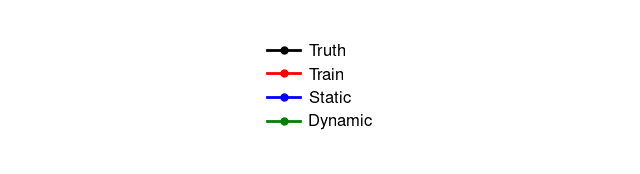

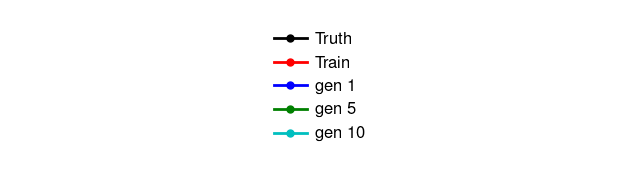

In [2]:
# Create a standalone legend figure
fig_legend, ax_legend = plt.subplots(figsize=(8, 2))
ax_legend.axis('off')  # Hide the axes

colors = ['k', 'r', 'b', 'g', 'c']
labels = [r'Truth', r'Train', r'Static', r'Dynamic']

# Use custom legend handles with markers and lines
custom_lines = [
    Line2D([0], [0], color=colors[0], marker='o', lw=2, label=labels[0]),
    Line2D([0], [0], color=colors[1], marker='o', lw=2, label=labels[1]),
    Line2D([0], [0], color=colors[2], marker='o', lw=2, label=labels[2]),
    Line2D([0], [0], color=colors[3], marker='o', lw=2, label=labels[3])
]

# Create the legend
legend = ax_legend.legend(handles=custom_lines, 
                         loc='center', 
                         frameon=False, 
                         ncol=1,  # Number of columns
                         handlelength=2, 
                         handletextpad=0.5,
                         columnspacing=1.5)

# Save the legend as a separate figure
plt.savefig(os.path.join(plt_save_dir, 'legend.png'), dpi=600, bbox_inches='tight')
plt.savefig(os.path.join(plt_save_dir, 'legend.svg'), dpi=600, bbox_inches='tight')

fig_legend, ax_legend = plt.subplots(figsize=(8, 2))
ax_legend.axis('off')  # Hide the axes

labels = [r'Truth', r'Train', r'gen 1', r'gen 5', r'gen 10']
# Use custom legend handles with markers and lines
custom_lines = [
    Line2D([0], [0], color=colors[0], marker='o', lw=2, label=labels[0]),
    Line2D([0], [0], color=colors[1], marker='o', lw=2, label=labels[1]),
    Line2D([0], [0], color=colors[2], marker='o', lw=2, label=labels[2]),
    Line2D([0], [0], color=colors[3], marker='o', lw=2, label=labels[3]),
    Line2D([0], [0], color=colors[4], marker='o', lw=2, label=labels[4])
]

# Create the legend
legend = ax_legend.legend(handles=custom_lines, 
                         loc='center', 
                         frameon=False, 
                         ncol=1,  # Number of columns
                         handlelength=2, 
                         handletextpad=0.5,
                         columnspacing=1.5)

# Save the legend as a separate figure
plt.savefig(os.path.join(plt_save_dir, 'legend_all_gen.png'), dpi=600, bbox_inches='tight')
plt.savefig(os.path.join(plt_save_dir, 'legend_all_gen.svg'), dpi=600, bbox_inches='tight')

# plt.show()

In [64]:
# Calculate mean divergence



for count in range(3):
    analysis_dir_arr = [analysis_dir_truth, TRAIN_ARR[count]]
    
    for emulator in EMULATOR_ARR[count]:
        analysis_dir_emulator, _, config = setup_emulator_analysis(emulator['root_dir'], emulator['run_name'])
        analysis_dir_arr.append(analysis_dir_emulator)

    for analysis_dir in analysis_dir_arr:
        data = np.load(analysis_dir + "/div.npz")
        div = data['div']

        print(f"{analysis_dir}: Mean divergence = {np.mean(np.abs(div)):.2e}, Max divergence = {np.max(np.abs(div)):.2e}, Std divergence = {np.std(div):.2e}")

/home/exouser/karan2/2DTurbDiffusion/eval/results/truth/A/: Mean divergence = 1.81e-06, Max divergence = 2.08e-06, Std divergence = 4.93e-08
/home/exouser/karan2/2DTurbDiffusion/eval/results/train_step3_400000_407500/analysis/train/: Mean divergence = 1.81e-06, Max divergence = 2.00e-06, Std divergence = 4.97e-08
/home/exouser/karan2/2DTurbDiffusion/results/UDM_s2_Oaw_lrC3e4_e800_2500/analysis/emulator: Mean divergence = 4.90e-02, Max divergence = 1.52e-01, Std divergence = 7.66e-03
/home/exouser/karan2/2DTurbDiffusion/results/CDM_s3_Oaw_lrC3e4_e800_2500/analysis/emulator: Mean divergence = 4.97e-02, Max divergence = 9.84e-02, Std divergence = 6.85e-03
/home/exouser/karan2/2DTurbDiffusion/eval/results/truth/A/: Mean divergence = 1.81e-06, Max divergence = 2.08e-06, Std divergence = 4.93e-08
/home/exouser/karan2/2DTurbDiffusion/eval/results/train_step3_10000_17500/analysis/train/: Mean divergence = 1.29e-06, Max divergence = 1.51e-06, Std divergence = 5.57e-08
/home/exouser/karan2/2DTur

In [4]:
import os, sys, glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import yaml

# import the modules
from analysis.metrics import corr_truth_train_model, rmse_truth_train_model
from analysis.return_period import return_period_bins, ensemble_return_period_amplitude, return_period_empirical
from analysis.io_utils import data2density
from analysis.plot_config import params, contourLevels, colormap
os.environ["PATH"] = f"/home/exouser/karan2/texlive/2025/bin/x86_64-linux:" + os.environ["PATH"] # use path of installed texlive

plt.rcParams.update(params)


# # ===== EMULATOR CONFIGURATION =====
model_collapse_type = 'all_gen'
root_dir = f'/home/exouser/karan2/2DTurbDiffusion/results/model_collapse/{model_collapse_type}/UDM_s3_Oaw_lrC3e4'

model_collapse_gen = [1, 5, 10]
#         'root_dir': f'/home/exouser/karan2/2DTurbDiffusion/results/model_collapse/{model_collapse_type}/UDM_s3_Oaw_lrC3e4_{model_collapse_type}_6/',

# ===== TRUTH AND TRAINING PATHS =====


analysis_dir_train = '/home/exouser/karan2/2DTurbDiffusion/eval/results/train_step3_10000_17500/analysis/train/'
analysis_dir_truth = '/home/exouser/karan2/2DTurbDiffusion/eval/results/truth/A/'
run_name = 'all'

# ===== FUNCTION TO SETUP EMULATOR ANALYSIS DIRECTORY =====
def setup_emulator_analysis(root_dir, run_name):
    """Setup analysis directory and config for an emulator"""
    yaml_files = glob.glob(os.path.join(root_dir, "*.yaml"))
    if len(yaml_files) == 0:
        raise FileNotFoundError(f"No .yaml files found in {root_dir}")
    
    with open(yaml_files[0], 'r') as f:
        config = yaml.safe_load(f)
    
    diffusion_config = config['diffusion_params']
    model_config = config['model_params']

    if diffusion_config['conditional'] and run_name != 'all':
        analysis_dir = os.path.join(root_dir, "analysis", "emulator", run_name)
        plt_save_dir = os.path.join(root_dir, "figures", run_name)

    else:
        analysis_dir = os.path.join(root_dir, "analysis", "emulator")
        plt_save_dir = os.path.join(root_dir, "figures")
    
    return analysis_dir, plt_save_dir, config



Nx, Ny = 64, 64  # Assuming Nx and Ny are defined here, adjust as needed

analysis_dir_arr = [analysis_dir_truth, analysis_dir_train]
label = [r'Truth', r'Train']
colors_markers = ['-k', '--r', '-.b', '-.g', '-.c']
color=['k', 'r', 'b', 'g', 'c']

for gen in model_collapse_gen:
    if gen == 1:
        emulator_dir = f'{root_dir}/'
    else:
        emulator_dir = f'{root_dir}_{model_collapse_type}_{gen-1}/'
    analysis_dir_emulator, plt_save_dir, config = setup_emulator_analysis(emulator_dir, 'run_name')
    analysis_dir_arr.append(analysis_dir_emulator)
    label.append(f'gen {gen}')

if model_collapse_type == 'last_gen':
    suptitle = r'$\mathrm{last~gen}$'

plt_save_dir = 'paper_figures/'

Nx, Ny = 64, 64
Lx, Ly = 2*np.pi, 2*np.pi
dt_DNS = 0.0005
dt_emulator = 0.02


<>:54: SyntaxWarning: invalid escape sequence '\h'
<>:54: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipykernel_3487613/3693055881.py:54: SyntaxWarning: invalid escape sequence '\h'
  axes[3].set_title('$|\hat{u}|$', rotation=0)


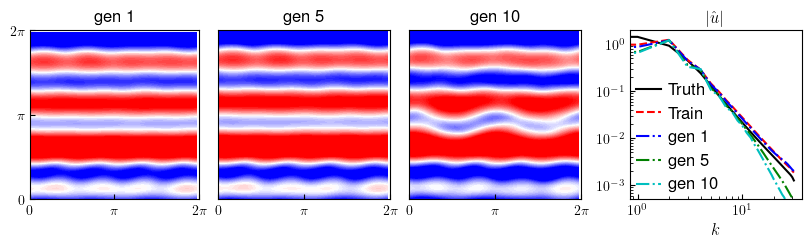

In [5]:
# Calculate mean divergence

fig, axes = plt.subplots(1,4,figsize=(8, 3), layout="compressed")  # Adjust figure size as needed


for i, analysis_dir in enumerate(analysis_dir_arr):

    data = np.load(analysis_dir + "/temporal_mean.npz")
    # data = np.load(analysis_dir_truth + "/temporal_mean.npz")

    U_mean_sample = data['U_sample_mean']
    V_mean_sample = data['V_sample_mean']
    Omega_mean_sample = data['Omega_sample_mean']

    if i == 0:
        vmax_U = 0.8*np.max(U_mean_sample)
        vmax_V = 0.8*np.max(V_mean_sample)
        vmax_Omega = 0.8*np.max(Omega_mean_sample)

    if i>1:
        axes[i-2].contourf(X,Y,U_mean_sample.T, levels=contourLevels, cmap=colormap, vmax=vmax_U, vmin=-vmax_U)
        # axes[i-2].contourf(X,Y,V_mean_sample.T, levels=contourLevels, cmap=colormap, vmax=vmax_V, vmin=-vmax_V)
        # axes[i-2].contourf(X,Y,Omega_mean_sample.T, levels=contourLevels, cmap=colormap, vmax=vmax_Omega, vmin=-vmax_Omega)

        axes[i-2].set_aspect('equal')
        axes[i-2].set_xticks([])
        axes[i-2].set_yticks([])
        axes[i-2].set_title(rf"{label[i]}")

        if i == 2:
            axes[i-2].set_yticks([0, np.pi, 2*np.pi])
            axes[i-2].set_yticklabels([r"$0$", r"$\pi$", r"$2\pi$"])
        else:
            axes[i-2].set_yticks([])
            axes[i-2].set_yticklabels([])

        axes[i-2].set_xticks([0, np.pi, 2*np.pi])
        axes[i-2].set_xticklabels([r"$0$", r"$\pi$", r"$2\pi$"])


    data = np.load(analysis_dir + "/spectra.npz")

    U_spectra = data['spectra_U_zonal_avg']
    V_spectra = data['spectra_V_zonal_avg']
    Omega_spectra = data['spectra_Omega_zonal_avg']
    wavenumbers = data['wavenumber_zonal_avg']

    axes[3].loglog(wavenumbers[:-1], U_spectra[:-1], colors_markers[i], label=label[i])
    # axes[count+1,3].loglog(wavenumbers[:-1], V_spectra[:-1], colors_markers[i], label=label[i])
    # axes[count+1,3].loglog(wavenumbers[:-1], Omega_spectra[:-1], colors_markers[i], label=label[i])

    axes[3].set_ylim([5e-4, 2e0])

axes[3].set_title('$|\hat{u}|$', rotation=0)
axes[3].legend(frameon=False, loc='lower left', bbox_to_anchor=(-0.05, -0.05), handlelength=1.5, handletextpad=0.4)
axes[3].set_xlabel('$k$')
plt.savefig(os.path.join(plt_save_dir, f'{model_collapse_type}.jpg'), dpi=600, bbox_inches='tight')
# plt.suptitle(suptitle)

In [100]:
# Calculate mean divergence

for analysis_dir in analysis_dir_arr:
    data = np.load(analysis_dir + "/div.npz")
    div = data['div']
    print(f" divergence Mean = {np.mean(np.abs(div)):.2e}, Max = {np.max(np.abs(div)):.2e}, Std divergence = {np.std(div):.2e}")

for analysis_dir in analysis_dir_arr:
    data = np.load(analysis_dir + "/energy.npz")
    energy = data['energy']
    print(f" energy Mean = {np.mean(np.abs(energy)):.2e}, Max = {np.max(np.abs(energy)):.2e}, Std energy = {np.std(energy):.2e}")

for analysis_dir in analysis_dir_arr:
    data = np.load(analysis_dir + "/enstrophy.npz")
    enstrophy = data['enstrophy']
    print(f" enstrophy Mean = {np.mean(np.abs(enstrophy)):.2e}, Max = {np.max(np.abs(enstrophy)):.2e}, Std enstrophy = {np.std(enstrophy):.2e}")

 divergence Mean = 1.81e-06, Max = 2.08e-06, Std divergence = 4.93e-08
 divergence Mean = 1.81e-06, Max = 2.00e-06, Std divergence = 4.97e-08
 divergence Mean = 1.57e-01, Max = 2.48e+00, Std divergence = 2.03e-01
 divergence Mean = 2.09e+00, Max = 4.60e+00, Std divergence = 1.47e+00
 divergence Mean = 1.70e+00, Max = 3.96e+00, Std divergence = 1.35e+00
 divergence Mean = 2.04e+00, Max = 9.91e+00, Std divergence = 1.98e+00
 divergence Mean = 1.44e+00, Max = 8.05e+00, Std divergence = 1.45e+00
 divergence Mean = 9.14e-01, Max = 5.38e+00, Std divergence = 9.90e-01
 energy Mean = 1.17e+01, Max = 1.25e+01, Std energy = 1.88e-01
 energy Mean = 1.17e+01, Max = 1.21e+01, Std energy = 1.86e-01
 energy Mean = 4.13e+00, Max = 7.74e+00, Std energy = 2.54e-01
 energy Mean = 3.68e+01, Max = 4.83e+02, Std energy = 4.71e+01
 energy Mean = 3.98e+01, Max = 4.45e+02, Std energy = 5.28e+01
 energy Mean = 8.01e+01, Max = 6.13e+02, Std energy = 7.80e+01
 energy Mean = 7.87e+01, Max = 6.70e+02, Std energy = 

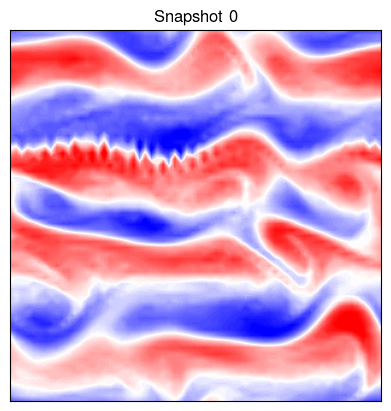

In [168]:
# Plot particular snapshot from the emulators


from py2d.convert import Omega2Psi, UV2Omega
from py2d.spectra import spectrum_zonal_average, spectrum_angled_average, TKE_angled_average
from py2d.initialize import initialize_wavenumbers_rfft2, gridgen, initialize_wavenumbers_fft2

data_dir = '/home/exouser/karan2/2DTurbDiffusion/results/CDM_s3_Oaw_lrC3e4/data/1_0/'

data = np.load(data_dir + "/26.npy")

Lx, Ly = 2 * np.pi, 2 * np.pi  # Domain size
Nx, Ny = 64, 64  # Number of grid points
Lx, Ly, X, Y, dx, dy = gridgen(Lx, Ly, Nx, Ny, INDEXING='ij')
Kx, Ky, Kabs, Ksq, invKsq = initialize_wavenumbers_rfft2(Nx, Ny, Lx, Ly, INDEXING='ij')

snap = 0


U = data[snap,0,:,:]
V = data[snap,1,:,:]
Omega = UV2Omega(U, V, Kx, Ky)

fig, ax = plt.subplots(figsize=(4, 4), layout="compressed")  # Adjust figure size as needed

vmax_Omega = 0.8 * np.max(np.abs(Omega))
ax.contourf(X,Y,Omega, levels=contourLevels, cmap=colormap, vmax=vmax_Omega, vmin=-vmax_Omega)
ax.set_aspect('equal')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title(f'Snapshot {snap}')

plt.savefig(os.path.join(plt_save_dir, 'omega_contour.jpg'), dpi=600, bbox_inches='tight')

Return Period for Training Data A
Shapes U_max:(9510016,), (38, 250000), U_min: (9510016,) (38, 250000)
Shapes U_max:(2501,), (1, 2501), U_min: (2501,) (1, 2501)
Shapes U_max:(556320,), (2, 250000), U_min: (556320,) (2, 250000)
Shapes U_max:(739424,), (2, 250000), U_min: (739424,) (2, 250000)
Shapes U_max:(4755008,), (19, 250000), U_min: (4755008,) (19, 250000)
Shapes U_max:(2501,), (1, 2501), U_min: (2501,) (1, 2501)
Shapes U_max:(556320,), (2, 250000), U_min: (556320,) (2, 250000)
Shapes U_max:(739424,), (2, 250000), U_min: (739424,) (2, 250000)
Return Period for Training Data B
Shapes U_max:(9510016,), (38, 250000), U_min: (9510016,) (38, 250000)
Shapes U_max:(2501,), (1, 2501), U_min: (2501,) (1, 2501)
Shapes U_max:(784000,), (3, 250000), U_min: (784000,) (3, 250000)
Shapes U_max:(1250002,), (5, 250000), U_min: (1250002,) (5, 250000)
Shapes U_max:(4755008,), (19, 250000), U_min: (4755008,) (19, 250000)
Shapes U_max:(2501,), (1, 2501), U_min: (2501,) (1, 2501)
Shapes U_max:(784000,)

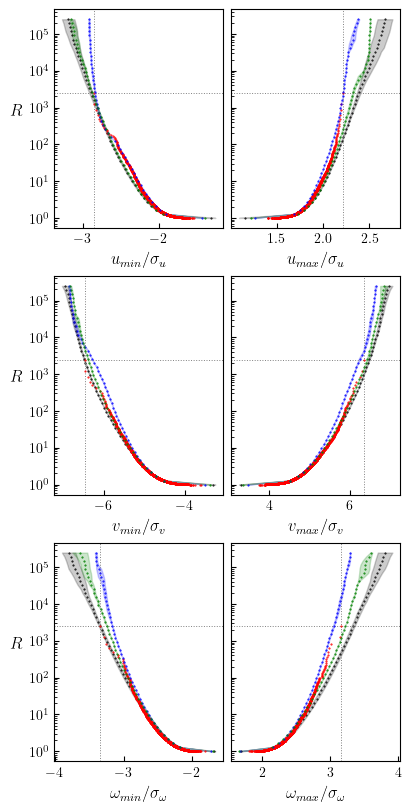

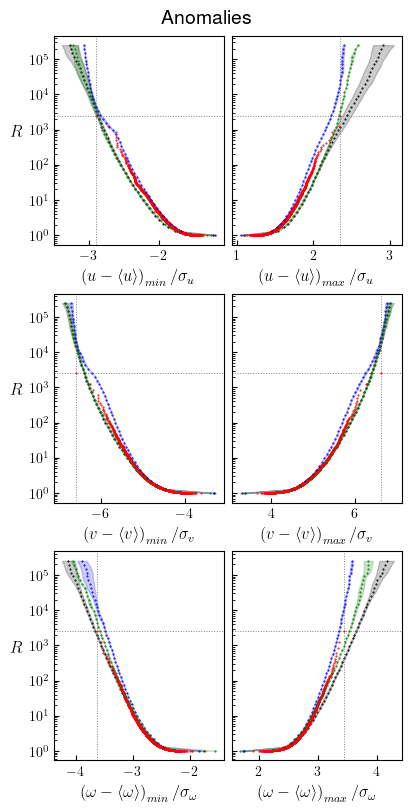

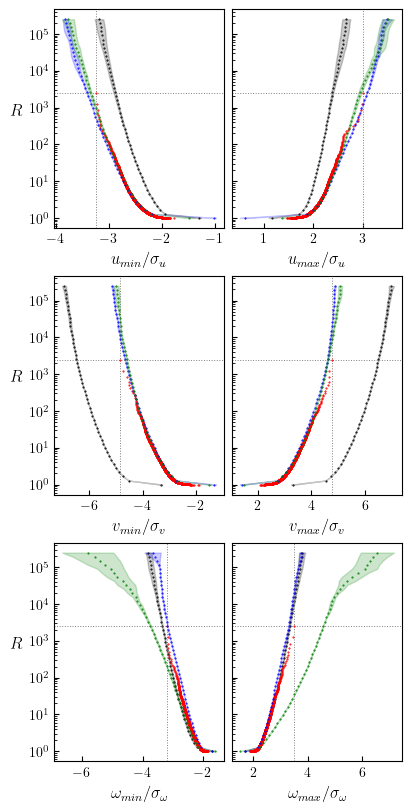

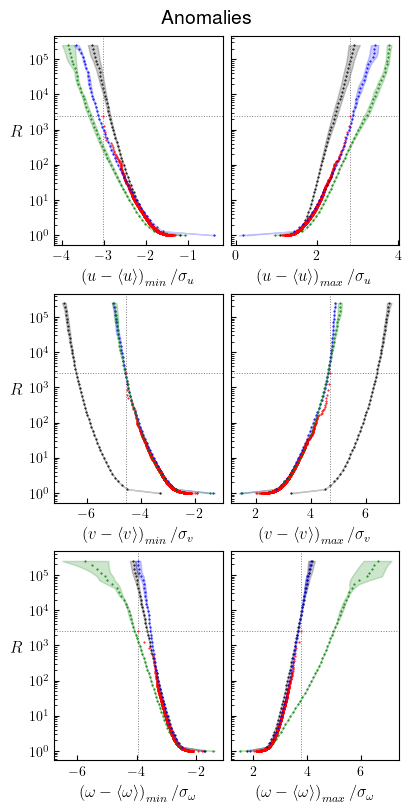

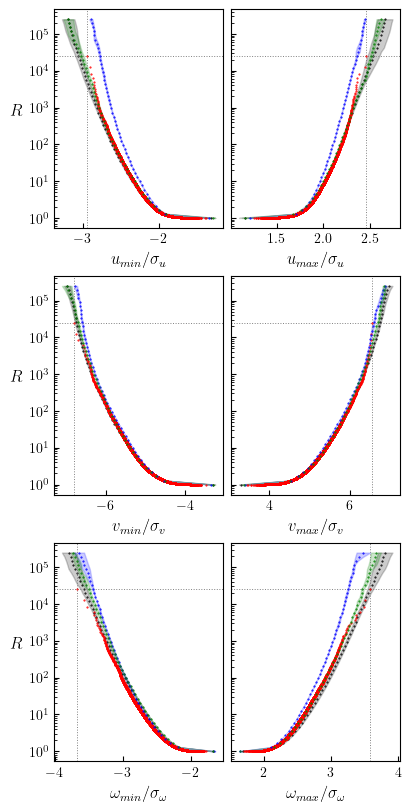

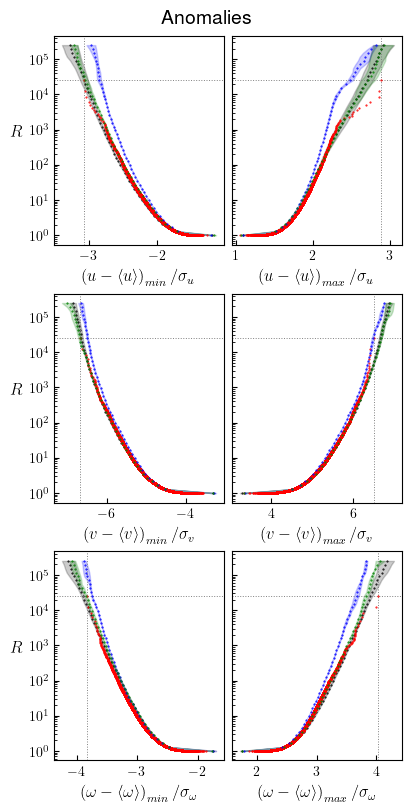

In [8]:

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

dt_data = 1
markersize = 0.5
U_std = 2.34
V_std = 1.88
Omega_std = 10.41
bins_num = 50

length_data = 250000  # Length of data for return period calculation

central_tendency = 'mean'  # mean median
error_bands = 'std'  # std 95ci 50ci

split = True
split_size = 2 # number of splits

def reshape_data_chunks(arr, target_length):
    """
    Reshape array into chunks of target_length, discarding extra data.
    
    Parameters:
    arr : array-like
        Input array to reshape
    target_length : int
        Target length for each chunk
        
    Returns:
    numpy.ndarray
        Reshaped array with shape [n_chunks, target_length] or [1, arr_length] if insufficient data
    """
    arr = np.asarray(arr)
    n_chunks = len(arr) // target_length
    if n_chunks > 0:
        return arr[:n_chunks * target_length].reshape(n_chunks, target_length)
    else:
        return arr.reshape(1, -1)  # If less than target_length elements, keep as single row


for count in range(3):
    analysis_dir_arr = [analysis_dir_truth, TRAIN_ARR[count]]
    
    for emulator in EMULATOR_ARR[count]:
        analysis_dir_emulator, _, config = setup_emulator_analysis(emulator['root_dir'], emulator['run_name'])
        analysis_dir_arr.append(analysis_dir_emulator)

    print(f"Return Period for Training Data {TRAIN_label_arr[count]}")


    for anom in [False, True]:
    # for anom in [False]:

        fig, axes = plt.subplots(3, 2, figsize=(4, 8), layout='constrained')
        plt.rcParams.update(params)
        
        for i, analysis_dir in enumerate(analysis_dir_arr):

            if anom:
                data = np.load(os.path.join(analysis_dir, 'extremes_anom.npz'))
            else:
                data = np.load(os.path.join(analysis_dir, 'extremes.npz'))

            U_max_arr = data['U_max_arr']/U_std
            U_min_arr = data['U_min_arr']/U_std
            V_max_arr = data['V_max_arr']/V_std
            V_min_arr = data['V_min_arr']/V_std
            Omega_max_arr = data['Omega_max_arr']/Omega_std
            Omega_min_arr = data['Omega_min_arr']/Omega_std
            arr = np.asarray(U_max_arr)

            # Apply the function
            U_max_arr_split = reshape_data_chunks(U_max_arr, length_data)
            U_min_arr_split = reshape_data_chunks(U_min_arr, length_data)
            V_max_arr_split = reshape_data_chunks(V_max_arr, length_data)
            V_min_arr_split = reshape_data_chunks(V_min_arr, length_data)
            Omega_max_arr_split = reshape_data_chunks(Omega_max_arr, length_data)
            Omega_min_arr_split = reshape_data_chunks(Omega_min_arr, length_data)


            print(f"Shapes U_max:{np.asarray(U_max_arr).shape}, {U_max_arr_split.shape}, U_min: {np.asarray(U_min_arr).shape} {U_min_arr_split.shape}")
            # print(f"Shapes V_max:{np.asarray(V_max_arr).shape}, {V_max_arr_split.shape}, V_min: {np.asarray(V_min_arr).shape} {V_min_arr_split.shape}")
            # print(f"Shapes Omega_max: {np.asarray(Omega_max_arr).shape} {Omega_max_arr_split.shape}, Omega_min: {np.asarray(Omega_min_arr).shape} {Omega_min_arr_split.shape}")

            if analysis_dir in TRAIN_ARR:

                U_max_return_period, U_max_data_amplitude = return_period_empirical(U_max_arr, dt=dt_data)
                U_min_return_period, U_min_data_amplitude = return_period_empirical(np.abs(U_min_arr), dt=dt_data)
                V_max_return_period, V_max_data_amplitude = return_period_empirical(V_max_arr, dt=dt_data)
                V_min_return_period, V_min_data_amplitude = return_period_empirical(np.abs(V_min_arr), dt=dt_data)
                Omega_max_return_period, Omega_max_data_amplitude = return_period_empirical(Omega_max_arr, dt=dt_data)
                Omega_min_return_period, Omega_min_data_amplitude = return_period_empirical(np.abs(Omega_min_arr), dt=dt_data)

                axes[0,0].axvline(-np.max(U_min_data_amplitude), color='grey', linestyle=':', linewidth=0.7)
                axes[0,0].axhline(np.max(U_min_return_period), color='grey', linestyle=':', linewidth=0.7)

                axes[0,1].axvline(np.max(U_max_data_amplitude), color='grey', linestyle=':', linewidth=0.7)
                axes[0,1].axhline(np.max(U_max_return_period), color='grey', linestyle=':', linewidth=0.7)

                axes[1,0].axvline(-np.max(V_min_data_amplitude), color='grey', linestyle=':', linewidth=0.7)
                axes[1,0].axhline(np.max(V_min_return_period), color='grey', linestyle=':', linewidth=0.7)

                axes[1,1].axvline(np.max(V_max_data_amplitude), color='grey', linestyle=':', linewidth=0.7)
                axes[1,1].axhline(np.max(V_max_return_period), color='grey', linestyle=':', linewidth=0.7)

                axes[2,0].axvline(-np.max(Omega_min_data_amplitude), color='grey', linestyle=':', linewidth=0.7)
                axes[2,0].axhline(np.max(Omega_min_return_period), color='grey', linestyle=':', linewidth=0.7)

                axes[2,1].axvline(np.max(Omega_max_data_amplitude), color='grey', linestyle=':', linewidth=0.7)
                axes[2,1].axhline(np.max(Omega_max_return_period), color='grey', linestyle=':', linewidth=0.7)


            else:
                U_max_return_period, U_max_data_amplitude, U_max_data_amplitude_lb, U_max_data_amplitude_ub = ensemble_return_period_amplitude(
                    np.asarray(np.abs(U_max_arr_split)), dt=dt_data, bins_num=bins_num, central_tendency=central_tendency, error_bands=error_bands)
                U_min_return_period, U_min_data_amplitude, U_min_data_amplitude_lb, U_min_data_amplitude_ub = ensemble_return_period_amplitude(
                    np.asarray(np.abs(U_min_arr_split)), dt=dt_data, bins_num=bins_num, central_tendency=central_tendency, error_bands=error_bands)
                V_max_return_period, V_max_data_amplitude, V_max_data_amplitude_lb, V_max_data_amplitude_ub = ensemble_return_period_amplitude(
                    np.asarray(np.abs(V_max_arr_split)), dt=dt_data, bins_num=bins_num, central_tendency=central_tendency, error_bands=error_bands)
                V_min_return_period, V_min_data_amplitude, V_min_data_amplitude_lb, V_min_data_amplitude_ub = ensemble_return_period_amplitude(
                    np.asarray(np.abs(V_min_arr_split)), dt=dt_data, bins_num=bins_num, central_tendency=central_tendency, error_bands=error_bands)
                Omega_max_return_period, Omega_max_data_amplitude, Omega_max_data_amplitude_lb, Omega_max_data_amplitude_ub = ensemble_return_period_amplitude(
                    np.asarray(np.abs(Omega_max_arr_split)), dt=dt_data, bins_num=bins_num, central_tendency=central_tendency, error_bands=error_bands)
                Omega_min_return_period, Omega_min_data_amplitude, Omega_min_data_amplitude_lb, Omega_min_data_amplitude_ub = ensemble_return_period_amplitude(
                    np.asarray(np.abs(Omega_min_arr_split)), dt=dt_data, bins_num=bins_num, central_tendency=central_tendency, error_bands=error_bands)


            axes[0,0].semilogy(-U_min_data_amplitude, U_min_return_period, 'o' + color[i],  markersize=markersize, label=label[i])
            axes[0,1].semilogy(U_max_data_amplitude, U_max_return_period, 'o' + color[i],  markersize=markersize, label=label[i])
            axes[1,0].semilogy(-V_min_data_amplitude, V_min_return_period, 'o' + color[i],  markersize=markersize, label=label[i])
            axes[1,1].semilogy(V_max_data_amplitude, V_max_return_period, 'o' + color[i],  markersize=markersize, label=label[i])
            axes[2,0].semilogy(-Omega_min_data_amplitude, Omega_min_return_period, 'o' + color[i],  markersize=markersize, label=label[i])
            axes[2,1].semilogy(Omega_max_data_amplitude, Omega_max_return_period, 'o' + color[i],  markersize=markersize, label=label[i])
            

            if analysis_dir not in TRAIN_ARR:
                axes[0,0].fill_betweenx(U_min_return_period, -U_min_data_amplitude_ub, -U_min_data_amplitude_lb, color=color[i], alpha=0.2)
                axes[0,1].fill_betweenx(U_max_return_period, U_max_data_amplitude_lb, U_max_data_amplitude_ub, color=color[i], alpha=0.2)
                axes[1,0].fill_betweenx(V_min_return_period, -V_min_data_amplitude_ub, -V_min_data_amplitude_lb, color=color[i], alpha=0.2)
                axes[1,1].fill_betweenx(V_max_return_period, V_max_data_amplitude_lb, V_max_data_amplitude_ub, color=color[i], alpha=0.2)
                axes[2,0].fill_betweenx(Omega_min_return_period, -Omega_min_data_amplitude_ub, -Omega_min_data_amplitude_lb, color=color[i], alpha=0.2)
                axes[2,1].fill_betweenx(Omega_max_return_period, Omega_max_data_amplitude_lb, Omega_max_data_amplitude_ub, color=color[i], alpha=0.2)

        if anom:
            axes[0,0].set_xlabel(r'$\left(u-\langle u\rangle\right)_{min}/\sigma_u$')
            axes[0,1].set_xlabel(r'$\left(u-\langle u\rangle\right)_{max}/\sigma_u$')
            axes[1,0].set_xlabel(r'$\left(v-\langle v\rangle\right)_{min}/\sigma_v$')
            axes[1,1].set_xlabel(r'$\left(v-\langle v\rangle\right)_{max}/\sigma_v$')
            axes[2,0].set_xlabel(r'$\left(\omega-\langle \omega\rangle\right)_{min}/\sigma_{\omega}$')
            axes[2,1].set_xlabel(r'$\left(\omega-\langle \omega\rangle\right)_{max}/\sigma_{\omega}$')

        else:
            axes[0,0].set_xlabel(r'$u_{min}/\sigma_u$')
            axes[0,1].set_xlabel(r'$u_{max}/\sigma_u$')
            axes[1,0].set_xlabel(r'$v_{min}/\sigma_v$')
            axes[1,1].set_xlabel(r'$v_{max}/\sigma_v$')
            axes[2,0].set_xlabel(r'$\omega_{min}/\sigma_{\omega}$')
            axes[2,1].set_xlabel(r'$\omega_{max}/\sigma_{\omega}$')

        axes[0,0].set_ylabel(r'$R$', rotation=0, labelpad=10)
        axes[1,0].set_ylabel(r'$R$', rotation=0, labelpad=10)
        axes[2,0].set_ylabel(r'$R$', rotation=0, labelpad=10)

        for ax in [axes[0,1], axes[1,1], axes[2,1]]:
            ax.set_yticklabels([])

        if TRAIN_label_arr[count] == 'A2500' or TRAIN_label_arr[count] == 'A25000':
            axes[0,0].set_xlim([-3.5, -1.05])
            axes[0,1].set_xlim([1.05, 3.5])
            axes[1,0].set_xlim([-7.2, -3])
            axes[1,1].set_xlim([3, 7.2])
            axes[2,0].set_xlim([-4.2, -1.5])
            axes[2,1].set_xlim([1.5, 4.2])



        elif TRAIN_label_arr[count] == 'B2500':
            axes[0,0].set_xlim([-4, -1.05])
            axes[0,1].set_xlim([1.05, 4])
            axes[1,0].set_xlim([-7.2, -1.05])
            axes[1,1].set_xlim([1.05, 7.2])
            axes[2,0].set_xlim([-6, -1.5])
            axes[2,1].set_xlim([1.5, 6])




####
        # # Use custom legend handles with dashed lines instead of marker symbols
        # custom_lines = [
        #     Line2D([0], [0], color=color[0], marker='o', lw=2, label=label[0]),
        #     Line2D([0], [0], color=color[1], marker='o', lw=2, label=label[1]),
        #     Line2D([0], [0], color=color[2], marker='o', lw=2, label=label[2]),
        #     Line2D([0], [0], color=color[3], marker='o', lw=2, label=label[3])
        # ]
        # if TRAIN_ARR[count] == 'B2500':
        #     axes[0,0].legend(handles=custom_lines, frameon=False)


        # Save figure with different filenames for anom True/False
        if anom:
            plt.suptitle('Anomalies')
            plt.savefig(plt_save_dir + f'/{TRAIN_label_arr[count]}_no_inset_return_period_anom.png', dpi=600, bbox_inches='tight')
            plt.savefig(plt_save_dir + f'/{TRAIN_label_arr[count]}_no_inset_return_period_anom.svg', dpi=600, bbox_inches='tight')

        else:
            plt.savefig(plt_save_dir + f'/{TRAIN_label_arr[count]}_no_inset_return_period.png', dpi=600, bbox_inches='tight')
            plt.savefig(plt_save_dir + f'/{TRAIN_label_arr[count]}_no_inset_return_period.svg', dpi=600, bbox_inches='tight')


<>:97: SyntaxWarning: invalid escape sequence '\h'
<>:97: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipykernel_3490836/3929519409.py:97: SyntaxWarning: invalid escape sequence '\h'
  axes[count+1,3].set_title('$|\hat{u}|$', rotation=0)


Loading spectra from /home/exouser/karan2/2DTurbDiffusion/eval/results/truth/A//spectra.npz
Loading spectra from /home/exouser/karan2/2DTurbDiffusion/eval/results/train_step3_400000_407500/analysis/train//spectra.npz
Loading spectra from /home/exouser/karan2/2DTurbDiffusion/results/UDM_s2_Oaw_lrC3e4_e800_2500/analysis/emulator/spectra.npz
Loading spectra from /home/exouser/karan2/2DTurbDiffusion/results/CDM_s3_Oaw_lrC3e4_e800_2500/analysis/emulator/spectra.npz
Loading spectra from /home/exouser/karan2/2DTurbDiffusion/eval/results/truth/A//spectra.npz
Loading spectra from /home/exouser/karan2/2DTurbDiffusion/eval/results/train_step3_10000_17500/analysis/train//spectra.npz
Loading spectra from /home/exouser/karan2/2DTurbDiffusion/results/UDM_s3_Oaw_lrC3e4/analysis/emulator/spectra.npz
Loading spectra from /home/exouser/karan2/2DTurbDiffusion/results/CDM_s3_Oaw_lrC3e4/analysis/emulator/spectra.npz
Loading spectra from /home/exouser/karan2/2DTurbDiffusion/eval/results/truth/A//spectra.npz


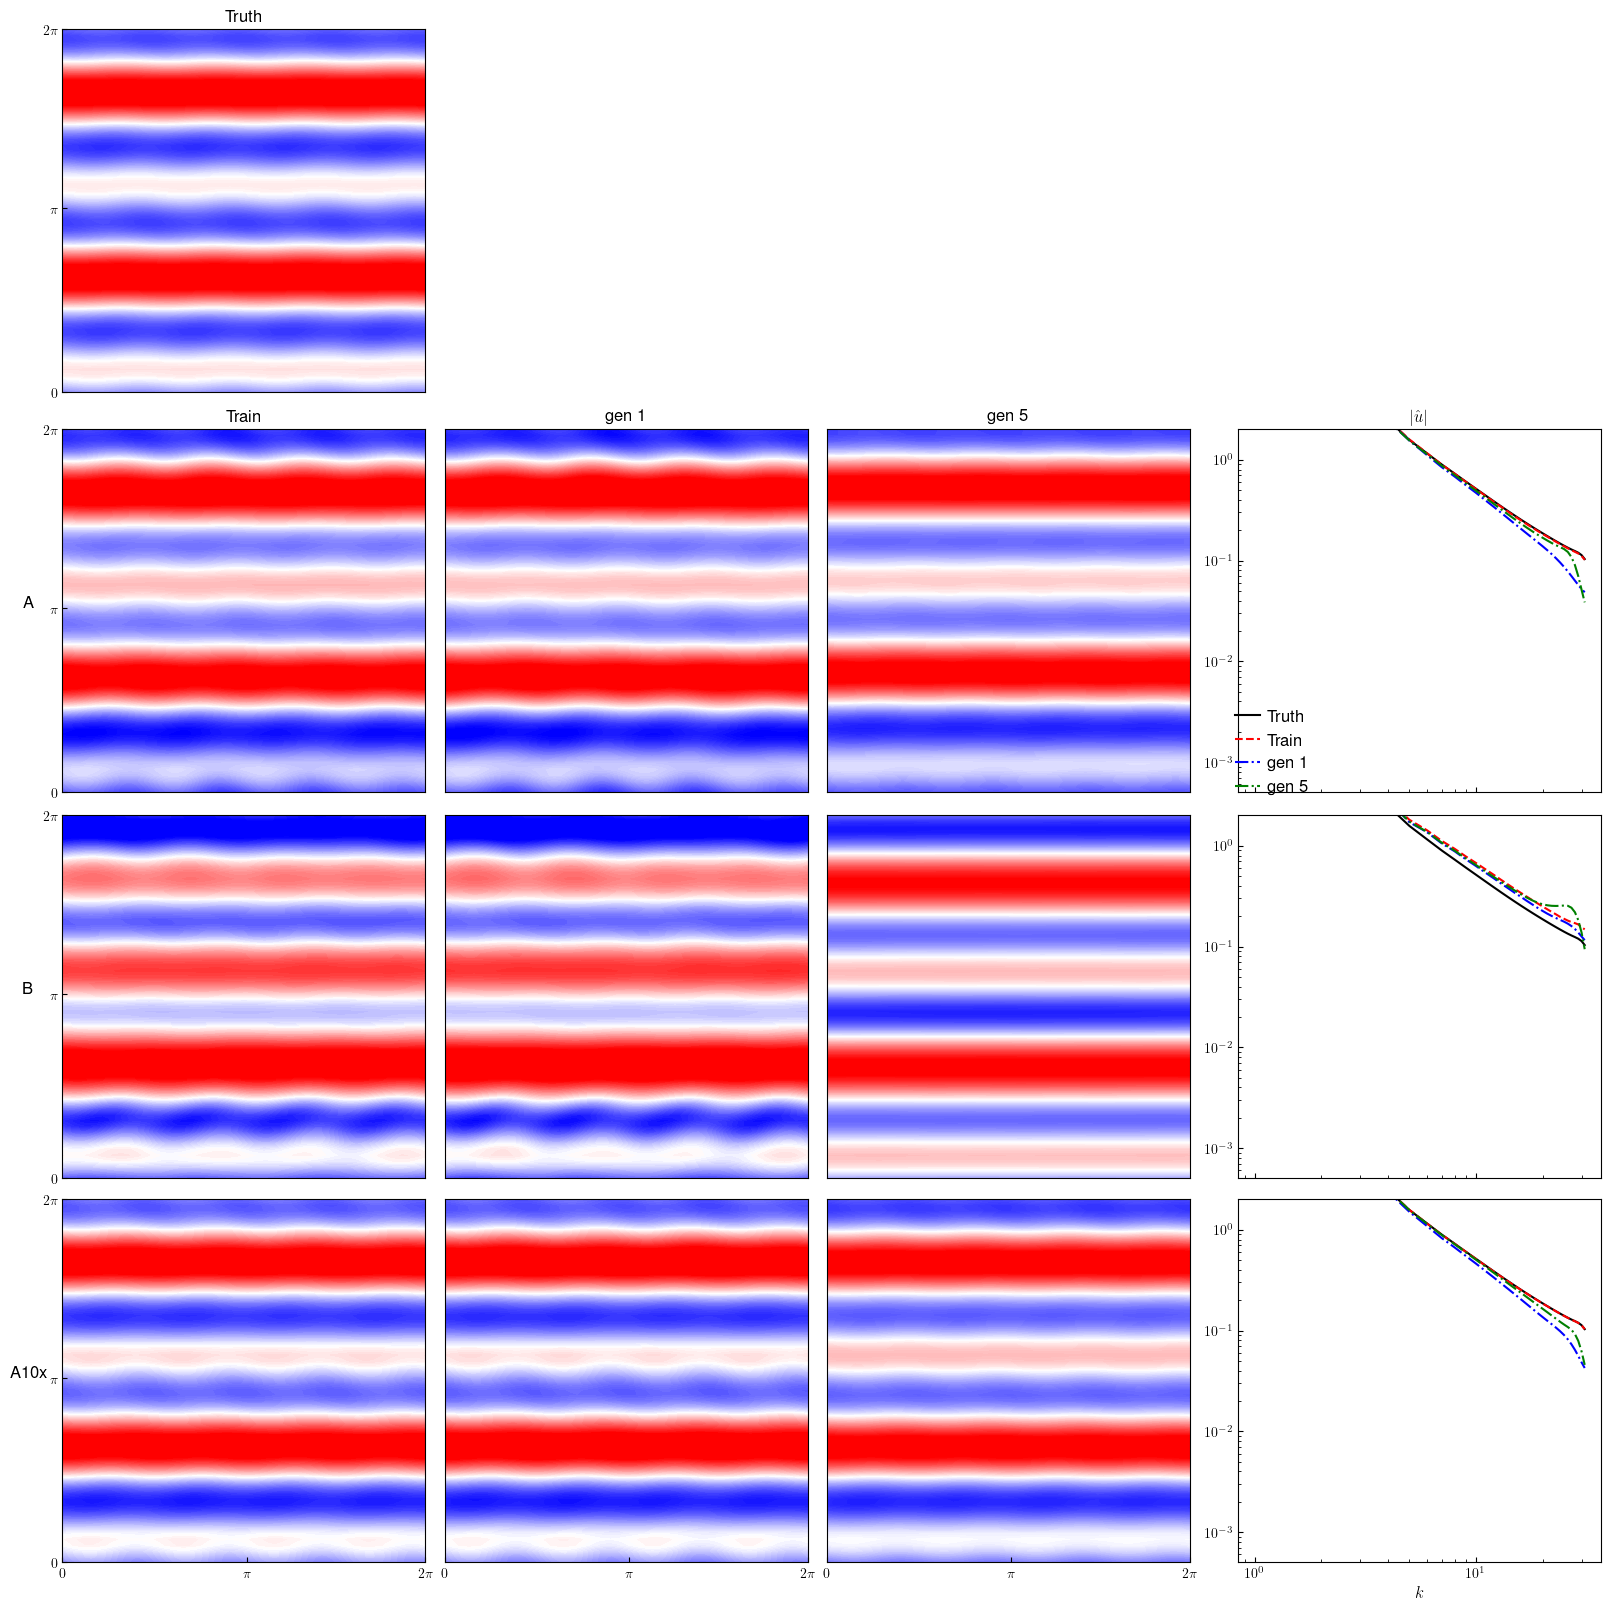

In [10]:
fig, axes = plt.subplots(4,4,figsize=(16, 16), layout="compressed")  # Adjust figure size as needed

contourLevels = 100
# ===== PLOTTING SETUP =====


for count in range(4):

    if count == 0:
        analysis_dir_arr = [analysis_dir_truth]
        
    else:
        analysis_dir_arr = [TRAIN_ARR[count-1]]
        for emulator in EMULATOR_ARR[count-1]:
            analysis_dir_emulator, _, config = setup_emulator_analysis(emulator['root_dir'], emulator['run_name'])
            analysis_dir_arr.append(analysis_dir_emulator)

    for i, analysis_dir in enumerate(analysis_dir_arr):

        data = np.load(analysis_dir + "/temporal_mean.npz")
        # data = np.load(analysis_dir_truth + "/temporal_mean.npz")

        U_mean_sample = data['U_sample_mean']
        V_mean_sample = data['V_sample_mean']
        Omega_mean_sample = data['Omega_sample_mean']

        if i == 0:
            vmax_U = 0.8*np.max(U_mean_sample)
            vmax_V = 0.8*np.max(V_mean_sample)
            vmax_Omega = 0.8*np.max(Omega_mean_sample)

        axes[count,i].contourf(X,Y,U_mean_sample.T, levels=contourLevels, cmap=colormap, vmax=vmax_U, vmin=-vmax_U)
        # axes[count,i].contourf(X,Y,V_mean_sample.T, levels=contourLevels, cmap=colormap, vmax=vmax_V, vmin=-vmax_V)
        # axes[count,i].contourf(X,Y,Omega_mean_sample.T, levels=contourLevels, cmap=colormap, vmax=vmax_Omega, vmin=-vmax_Omega)

        # axes[0,i].set_title(rf"$u$ {label[i]}")
        # axes[1,i].set_title(rf"$v$ {label[i]}")
        axes[count,i].set_aspect('equal')
        axes[count,i].set_xticks([])
        axes[count,i].set_yticks([])

        if i == 0:
            axes[count,i].set_yticks([0, np.pi, 2*np.pi-dx])
            axes[count,i].set_yticklabels([r"$0$", r"$\pi$", r"$2\pi$"])
            if count > 0:
                axes[count,i].set_ylabel(f"{TRAIN_label_arr[count-1]}", rotation=0, labelpad=10)

        if count == 0:
            axes[count,i].set_title(rf"{label[i]}")

            for i in range(1,4):
                axes[count,i].set_visible(False)

        elif count == 1:
            axes[count,i].set_title(rf"{label[i+1]}")



        if count == 3:
            axes[count,i].set_xticks([0, np.pi, 2*np.pi-dx])
            axes[count,i].set_xticklabels([r"$0$", r"$\pi$", r"$2\pi$"])



for count in range(3):
    analysis_dir_arr = [analysis_dir_truth, TRAIN_ARR[count]]
    
    for emulator in EMULATOR_ARR[count]:
        analysis_dir_emulator, _, config = setup_emulator_analysis(emulator['root_dir'], emulator['run_name'])
        analysis_dir_arr.append(analysis_dir_emulator)


    for i, analysis_dir in enumerate(analysis_dir_arr):

        data = np.load(analysis_dir + "/spectra.npz")
        print(f"Loading spectra from {analysis_dir}/spectra.npz")

        U_spectra = data['spectra_U_zonal_avg']
        V_spectra = data['spectra_V_zonal_avg']
        Omega_spectra = data['spectra_Omega_zonal_avg']
        wavenumbers = data['wavenumber_zonal_avg']

        # U_spectra = data['spectra_U_angular_avg']
        # V_spectra = data['spectra_V_angular_avg']
        # Omega_spectra = data['spectra_Omega_angular_avg']
        # wavenumbers = data['wavenumber_angular_avg']

        # axes[count+1,3].loglog(wavenumbers[:-1], U_spectra[:-1], colors_markers[i], label=label[i])
        # axes[count+1,3].loglog(wavenumbers[:-1], V_spectra[:-1], colors_markers[i], label=label[i])
        axes[count+1,3].loglog(wavenumbers[:-1], Omega_spectra[:-1], colors_markers[i], label=label[i])

        axes[count+1,3].set_ylim([5e-4, 2e0])

        # axes[0].set_title('$\hat{u}$', rotation=0)
        # axes[1].set_title('$\hat{v}$', rotation=0)
        if count == 0:
            axes[count+1,3].set_title('$|\hat{u}|$', rotation=0)
            axes[count+1,3].legend(frameon=False, loc='lower left', bbox_to_anchor=(-0.05, -0.05), handlelength=1.5, handletextpad=0.4)

        if count == 2:
            axes[count+1,3].set_xlabel('$k$')
        else:
            axes[count+1,3].set_xticklabels([])

plt.savefig(os.path.join(plt_save_dir, 'u_sample_mean_spectra.jpg'), dpi=600, bbox_inches='tight')